# Decision trees

## Helpers

In [51]:
import pandas as pd

def read_data_sets(path_train, path_test):
    return pd.read_csv(path_train), pd.read_csv(path_test) 

def calculate_accuracy(answers, classes):
    return sum([x == y for x, y in zip(answers, classes)]) / len(answers)

def preopen_datasets():
    trains_x = []
    tests_x = []
    trains_y = []
    tests_y = []
    for i in range(1, 22):
        prefix = "/home/vutaliy/Downloads/DT/"
    
        if i < 10:
            prefix += "0"
        prefix += "{0}".format(i)
    
        train, test = read_data_sets(prefix + "_train.csv", prefix + "_test.csv")

        train_x = train.iloc[:, :train.shape[1] - 1].to_numpy()
        trains_x.append(train_x)

        train_y = train.loc[:, "y"].to_numpy()
        trains_y.append(train_y)

        test_x = test.iloc[:, :test.shape[1] - 1].to_numpy()
        tests_x.append(test_x)

        test_y = test.loc[:, "y"].to_numpy()
        tests_y.append(test_y)

    return trains_x, trains_y, tests_x, tests_y    

trains_x, trains_y, tests_x, tests_y = preopen_datasets()

## Find best criteries for trees

In [52]:
from sklearn.tree import DecisionTreeClassifier
criterions = { "gini", "entropy" }
splitters = { "best", "random" }

def find_best_criteries():
    accuracies = [[0,"","",0]] * 21
    for criterion in criterions:
        for splitter in splitters:
            for max_depth in range(1,20):
                
                tree = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
                for i in range(1, 22):
                    tree.fit(trains_x[i - 1], trains_y[i - 1])
                    preds = tree.predict(tests_x[i - 1])
                    
                    accuracy = calculate_accuracy(preds, tests_y[i - 1])
                    if accuracy > accuracies[i - 1][0]:
                        accuracies[i - 1] = [accuracy, criterion, splitter, max_depth]
        print(criterion)
    return accuracies

accs = find_best_criteries()
accs


entropy
gini


[[0.9997429966589566, 'entropy', 'best', 3],
 [0.7055979643765903, 'entropy', 'best', 9],
 [1.0, 'entropy', 'best', 1],
 [0.992, 'entropy', 'best', 5],
 [0.9956709956709957, 'entropy', 'best', 1],
 [0.9988962472406181, 'entropy', 'best', 3],
 [0.9967441860465116, 'entropy', 'best', 3],
 [0.997920997920998, 'entropy', 'best', 2],
 [0.8470588235294118, 'entropy', 'best', 5],
 [0.9979879275653923, 'entropy', 'best', 4],
 [0.999195171026157, 'entropy', 'best', 1],
 [0.8781925343811395, 'entropy', 'best', 10],
 [0.6522935779816513, 'entropy', 'best', 7],
 [0.990351215746816, 'entropy', 'best', 5],
 [1.0, 'entropy', 'best', 1],
 [1.0, 'entropy', 'best', 1],
 [0.8492462311557789, 'entropy', 'best', 7],
 [0.9426656738644825, 'entropy', 'best', 5],
 [0.8304576144036009, 'entropy', 'best', 7],
 [0.9706814580031695, 'entropy', 'best', 7],
 [0.807863031071655, 'entropy', 'best', 15]]

In [53]:
def find_depths():
    cur_min = float("inf")
    cur_max = float("-inf")
    ans_min = []
    ans_max = []
    num_min = 0
    num_max = 0
    
    for ix, i in enumerate(accs):
        
        if i[3] < cur_min:
            cur_min = i[3]
            ans_min = i
            num_min = ix
        
        if i[3] > cur_max:
            cur_max = i[3]
            ans_max = i
            num_max = ix
    
    return ans_min, num_min, ans_max, num_max

crit_min_depth, num_min, crit_max_depth, num_max = find_depths()
print(crit_min_depth, crit_max_depth)


[1.0, 'entropy', 'best', 1] [0.807863031071655, 'entropy', 'best', 15]


## Plots for min and max depths trees

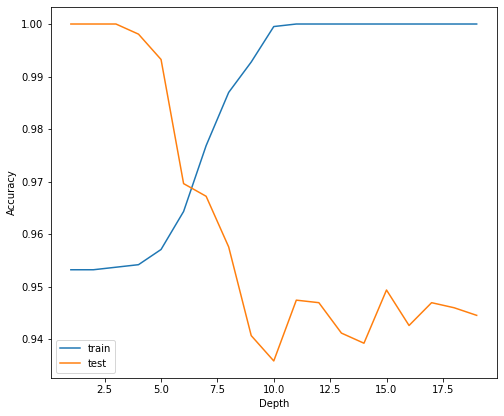

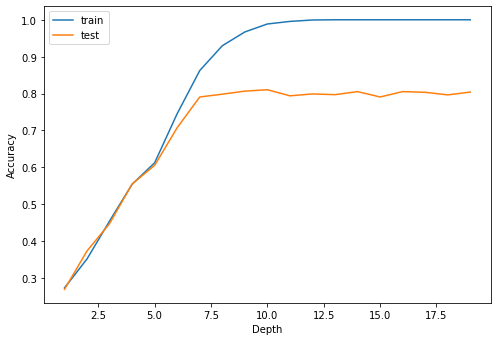

In [57]:
import matplotlib.pyplot as plt 

depths = [i for i in range(1,20)]

def calculate_deps_plt(depths, criteries, num):
    accuracies_tests = []
    accuracies_trains = []
    for i in depths:
        tree = DecisionTreeClassifier(criterion=criteries[1], splitter=criteries[2], max_depth=i)
        
        tree.fit(trains_x[num], trains_y[num])
        preds_train = tree.predict(trains_x[num])
        preds_test = tree.predict(tests_x[num])

        accuracy_train = calculate_accuracy(preds_train, trains_y[num])
        accuracy_test = calculate_accuracy(preds_test, tests_y[num])

        accuracies_trains.append(accuracy_train)
        accuracies_tests.append(accuracy_test)

    return accuracies_trains, accuracies_tests

min_trains_accs, min_tests_accs = calculate_deps_plt(depths, crit_min_depth, num_min)
max_trains_accs, max_tests_accs = calculate_deps_plt(depths, crit_max_depth, num_max)

plt.subplot(2, 1, 1)

plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.plot(depths, min_trains_accs, label = "train")
plt.plot(depths, min_tests_accs, label = "test")

plt.legend()
plt.rcParams["figure.figsize"] = (8,12)
plt.show()

plt.subplot(2, 1, 2)

plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.plot(depths, max_trains_accs, label = "train")
plt.plot(depths, max_tests_accs, label = "test")

plt.legend()
plt.rcParams["figure.figsize"] = (8,12)
plt.show()



## Random forest

In [92]:
import random as rnd
import numpy as np

class RandomForest():
    def __init__(self, size = 20):
        self.size = size
        self.forest = []
        self.cur_forest_size = 0
    
    def __fit_one(self, train_x, train_y, criterion="entropy", splitter="best", max_features="sqrt"):
        if self.cur_forest_size == self.size:
            return
        
        rands = self.generate_random(train_x.shape[0])
        new_train_x = []
        new_train_y = []
        
        for i in rands:
            new_train_x.append(train_x[i])
            new_train_y.append(train_y[i])
        new_train_x = np.array(new_train_x)
        new_train_y = np.array(new_train_y)

        tree = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_features=max_features)
        tree.fit(new_train_x, new_train_y)
        self.forest.append(tree)

    def fit(self, X, y):
        for i in range(self.size):
            self.__fit_one(X, y)
    
    def __predict_one(self, one_x, size_ys):
        _classes = [0] * (size_ys + 1)
        for tree in self.forest:
            _classes[tree.predict([one_x])[0]] += 1
        return _classes.index(max(_classes))

    def predict_and_score(self, X, ys):
        size = len(ys)
        ans = []
        for x in X:
            ans.append(self.__predict_one(x, size))
        return self.score(ans, ys)
        
    @staticmethod
    def generate_random(size):
        return [rnd.randrange(size) for i in range(size)]

    @staticmethod
    def score(answers, classes):
        return sum([x == y for x, y in zip(answers, classes)]) / len(answers)

        
forest = RandomForest()
forest.fit(trains_x[0], trains_y[0])
forest.predict_and_score(tests_x[0], tests_y[0])

0.9989719866358263

In [ ]:
scores_train = []
scores_test = []

for i in range(0,21):
    forest = RandomForest()
    forest.fit(trains_x[i], trains_y[i])
    scores_test.append(forest.predict_and_score(tests_x[i], tests_y[i]))
    scores_train.append(forest.predict_and_score(trains_x[i], trains_y[i]))
print(scores_test, scores_train)

## Plot for random forest

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Set number {0}'.format(i) for i in range(1,22)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scores_train, width, label='Train')
rects2 = ax.bar(x + width/2, scores_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()